## Import libraries

In [1]:
import os
import cv2
import random

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## unzip the folders

In [2]:
!unzip val-cat-rabbit.zip
!unzip train-cat-rabbit.zip

Archive:  val-cat-rabbit.zip
   creating: val-cat-rabbit/
  inflating: __MACOSX/._val-cat-rabbit  
   creating: val-cat-rabbit/cat/
  inflating: __MACOSX/val-cat-rabbit/._cat  
   creating: val-cat-rabbit/rabbit/
  inflating: __MACOSX/val-cat-rabbit/._rabbit  
  inflating: val-cat-rabbit/cat/cat.6.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.6.jpg  
  inflating: val-cat-rabbit/cat/cat.205.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.205.jpg  
  inflating: val-cat-rabbit/cat/cat.198.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.198.jpg  
  inflating: val-cat-rabbit/cat/cat.30.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.30.jpg  
  inflating: val-cat-rabbit/cat/cat.24.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.24.jpg  
  inflating: val-cat-rabbit/cat/cat.167.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.167.jpg  
  inflating: val-cat-rabbit/cat/cat.18.jpg  
  inflating: __MACOSX/val-cat-rabbit/cat/._cat.18.jpg  
  inflating: val-cat-rabbit/

## Load the dataset and plot 6 images of cat and rabbit

In [3]:
data_dir = "/content/train-cat-rabbit"
image_size = (300, 300)


# Load and preprocess the data
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        class_path = os.path.join(folder, subfolder)
        class_label = subfolder  # The subfolder name is used as the class label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.resize(img, image_size)
              images.append(img)
              labels.append(class_label)
    return np.array(images), np.array(labels)

x, y = load_images_from_folder(data_dir)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


# Add the color channel dimension
X_train = X_train.reshape(X_train.shape[0], image_size[0], image_size[1],3)
X_test = X_test.reshape(X_test.shape[0], image_size[0], image_size[1],3)

In [4]:
print("Shape of X_Train = ", X_train.shape)
print("Shape of y_train = ", y_train.shape)

print("Shape of X_test = ", X_test.shape)
print("Shape of y_test = ", y_test.shape)

Shape of X_Train =  (1280, 300, 300, 3)
Shape of y_train =  (1280,)
Shape of X_test =  (320, 300, 300, 3)
Shape of y_test =  (320,)


In [5]:
def plot_random_sample(images, labels, class_name, sample_size=6):
    plt.figure(figsize=(12, 6))
    plt.suptitle(class_name, fontsize=16)
    for i in range(sample_size):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
        plt.title(labels[idx])
        plt.axis('on')
    plt.show()



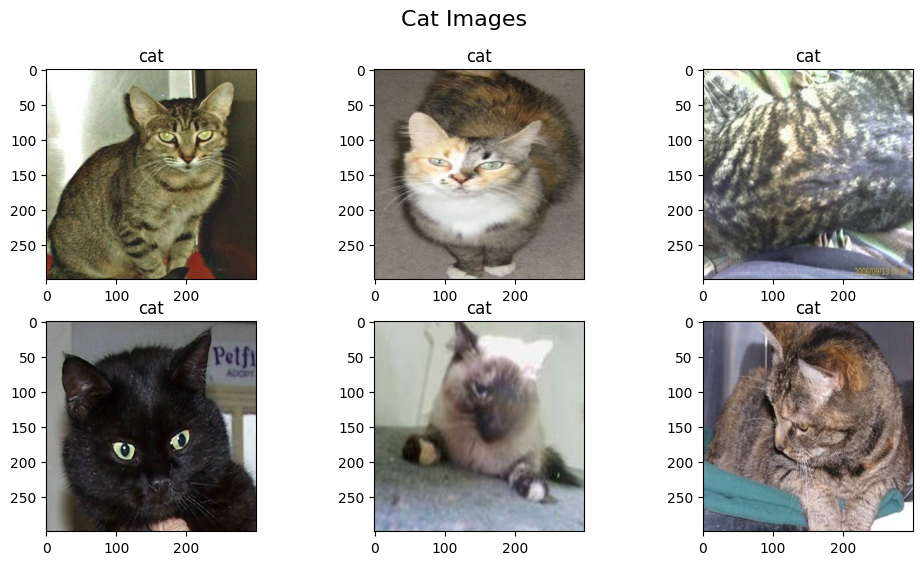

In [6]:
# show 6 images of cat
cat_images = X_train[y_train == 'cat']
cat_labels = y_train[y_train == 'cat']
plot_random_sample(cat_images, cat_labels, "Cat Images")


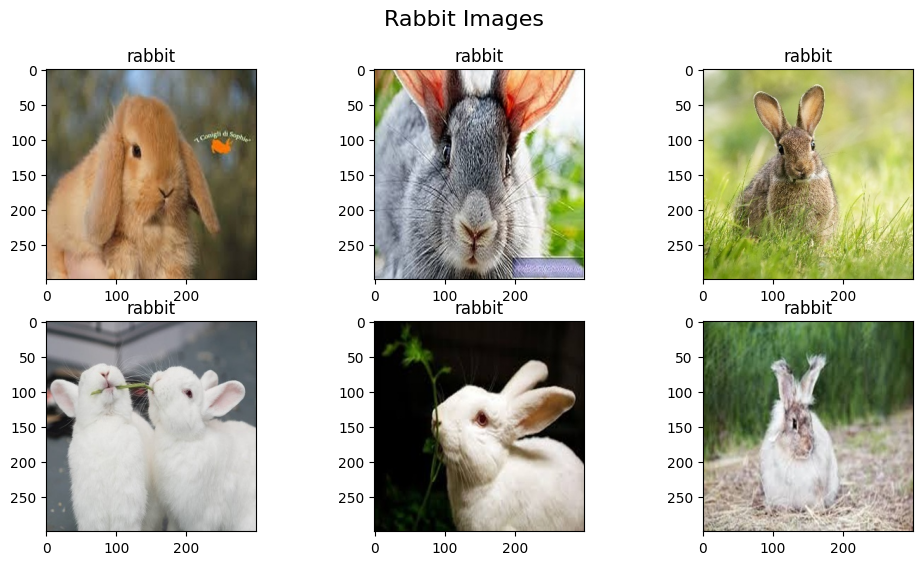

In [7]:
# show 6 images of rabbit
rabbit_images = X_train[y_train == 'rabbit']
rabbit_labels = y_train[y_train == 'rabbit']
plot_random_sample(rabbit_images, rabbit_labels, "Rabbit Images")

## Prepare training and testing data

In [8]:
# # normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# # one hot encode outputs
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
print("Shape of X_Train = ", X_train.shape)
print("Shape of y_train = ", y_train.shape)

print("Shape of X_test = ", X_test.shape)
print("Shape of y_test = ", y_test.shape)

Shape of X_Train =  (1280, 300, 300, 3)
Shape of y_train =  (1280, 2)
Shape of X_test =  (320, 300, 300, 3)
Shape of y_test =  (320, 2)


## Build the model

In [11]:
# # Create the LeNet Model
model = Sequential()

# # 2 convolution layers
model.add(Conv2D(filters=6,
                 kernel_size=(3, 3),
                 activation='tanh',
                 input_shape=(image_size[0], image_size[1],3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=16,
                 kernel_size=(3, 3),
                 activation='tanh'))
model.add(MaxPooling2D())

model.add(Flatten()) #from here its a fully connected NN

# 3 dense layers including final output layer
model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

epochs = 10

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 85264)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [12]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('lenet_cifar10_{epoch:02d}.h5') #period = 2

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.18, epochs=epochs, batch_size=128, callbacks =[checkpoint])

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 1.7379 - accuracy: 0.5081

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 62s 7s/step - loss: 1.7379 - accuracy: 0.5081 - val_loss: 1.1473 - val_accuracy: 0.5108
Epoch 2/10
9/9 [==============================] - 54s 6s/step - loss: 0.8294 - accuracy: 0.5005 - val_loss: 0.7800 - val_accuracy: 0.4892
Epoch 3/10
9/9 [==============================] - 53s 6s/step - loss: 0.7662 - accuracy: 0.5005 - val_loss: 0.7079 - val_accuracy: 0.4892
Epoch 4/10
9/9 [==============================] - 53s 6s/step - loss: 0.6931 - accuracy: 0.5348 - val_loss: 0.6919 - val_accuracy: 0.5108
Epoch 5/10
9/9 [==============================] - 55s 6s/step - loss: 0.6902 - accuracy: 0.4995 - val_loss: 0.6781 - val_accuracy: 0.5108
Epoch 6/10
9/9 [==============================] - 53s 6s/step - loss: 0.6735 - accuracy: 0.5052 - val_loss: 0.6625 - val_accuracy: 0.6926
Epoch 7/10
9/9 [==============================] - 55s 6s/step - loss: 0.6741 - accuracy: 0.6139 - val_loss: 0.6665 - val_accuracy: 0.6364
Epoch 8/10
9/9 [=============================

## Performance Metrics

In [25]:
#prepare the test dataset to rate the performance

test_dir = "/content/val-cat-rabbit"
image_size = (300, 300)


# Load and preprocess the data
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        class_path = os.path.join(folder, subfolder)
        class_label = subfolder  # The subfolder name is used as the class label
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.resize(img, image_size)
              images.append(img)
              labels.append(class_label)
    return np.array(images), np.array(labels)

x_new, y_new = load_images_from_folder(test_dir)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(x_new, y_new, test_size=0.2)


# Add the color channel dimension
X_train_new = X_train_new.reshape(X_train_new.shape[0], image_size[0], image_size[1],3)
X_test_new = X_test_new.reshape(X_test_new.shape[0], image_size[0], image_size[1],3)

In [26]:
print("Shape of X_Train = ", X_train_new.shape)
print("Shape of y_train = ", y_train_new.shape)

print("Shape of X_test = ", X_test_new.shape)
print("Shape of y_test = ", y_test_new.shape)

Shape of X_Train =  (331, 300, 300, 3)
Shape of y_train =  (331,)
Shape of X_test =  (83, 300, 300, 3)
Shape of y_test =  (83,)


In [27]:
# # normalize inputs from 0-255 to 0.0-1.0
X_train_new = X_train_new.astype('float32')
X_test_new = X_test_new.astype('float32')
X_train_new = X_train_new / 255.0
X_test_new = X_test_new / 255.0

In [28]:
# # one hot encode outputs
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_train_new = label_encoder.fit_transform(y_train_new)
y_test_new = label_encoder.transform(y_test_new)

one_hot_encoder = OneHotEncoder(sparse=False)
y_train_new = one_hot_encoder.fit_transform(y_train_new.reshape(-1, 1))
y_test_new = one_hot_encoder.transform(y_test_new.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [29]:
print("Shape of X_Train = ", X_train_new.shape)
print("Shape of y_train = ", y_train_new.shape)

print("Shape of X_test = ", X_test_new.shape)
print("Shape of y_test = ", y_test_new.shape)

Shape of X_Train =  (331, 300, 300, 3)
Shape of y_train =  (331, 2)
Shape of X_test =  (83, 300, 300, 3)
Shape of y_test =  (83, 2)


In [30]:
#Final evaluation of the model
scores = model.evaluate(X_test_new, y_test_new, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.4f" % (scores[0]))

Accuracy: 60.24%
Loss: 0.6339


In [31]:
#classification report
Y_pred = model.predict(X_test_new)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test_new, axis=1)

cr = classification_report(Y_test, Y_pred)
print(cr)

3/3 [==============================] - 1s 379ms/step
              precision    recall  f1-score   support

           0       0.54      0.92      0.68        38
           1       0.83      0.33      0.48        45

    accuracy                           0.60        83
   macro avg       0.69      0.63      0.58        83
weighted avg       0.70      0.60      0.57        83



[[35  3]
 [30 15]]


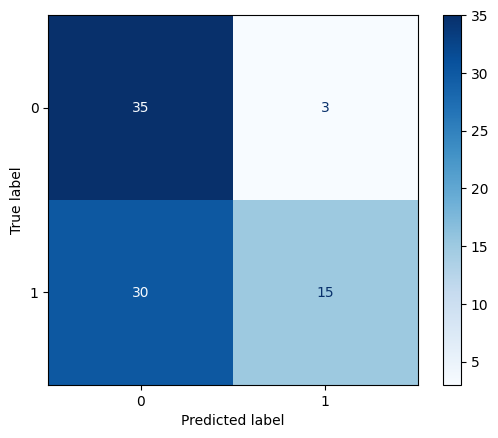

In [32]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

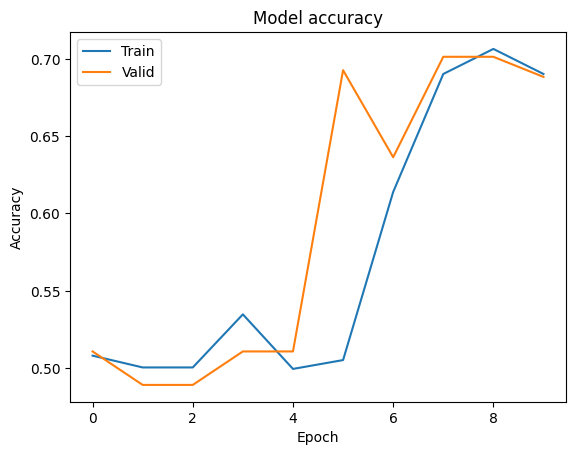

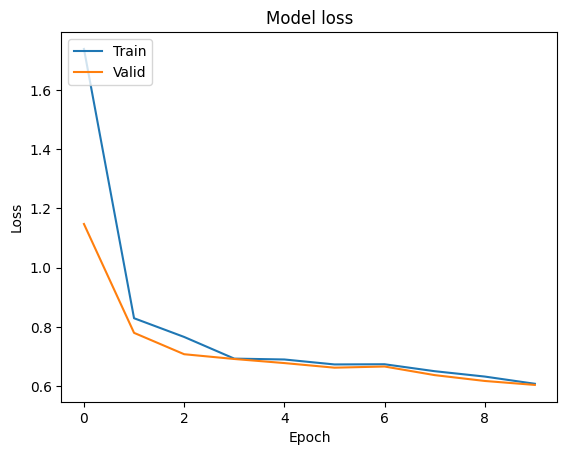

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

The accuracy of the model is at 60.24% which is fairly acceptable in predicting the correct image.